# Setups and Imports

In [41]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
sns.set
import spacy
import nltk
from nltk.corpus import brown
from nltk.corpus import wordnet
from collections import Counter
import Tweet_Normalizer as tn
from bs4 import BeautifulSoup
import requests
import spacy
import scipy
import gensim
from sklearn.model_selection import train_test_split
from nltk.tokenize.toktok import ToktokTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
import csv
import math
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow import keras

# Load the Data

In [2]:
tweets = pd.read_csv("data/train.csv")

# Clean and Normalize Tweets

In [5]:
%%time
#USe tweet scrubber function to clean the data
tweets = tn.tweet_scrubber(tweets, verbose = True)

Running tweet scrubber...

Dropping unnecessary columns
Successfully dropped columns!

Normalizing the tweets
Successfully normalized tweets!

Removing invalid and mispelled words
Successfully removed invalid and mispelled words!

Successfully scrubbed tweets!

Wall time: 4min 39s


In [8]:
#Check for blank rows after cleaning. We expect 5
tweets = tweets.replace(r'^(\s)+$', np.nan, regex = True)
#Drop the empty rows
tweets.dropna(subset=["Clean Tweets"], inplace = True)
#Reset the index in place
tweets.reset_index(drop = True, inplace = True)

In [10]:
#Take a look at the last few rows of the data
pd.set_option('display.max_colwidth', 2)
tweets.tail(n=15)

,text,target,Clean Tweets
7593,Father-of-three Lost Control of Car After Overtaking and Collided #BathAndNorthEastSomerset http://t.co/fa3FcnlN86,1,father three lose control car overtake collide
7594,1.3 #Earthquake in 9Km Ssw Of Anza California #iPhone users download the Earthquake app for more information http://t.co/V3aZWOAmzK,1,earthquake km ssw california user download earthquake information
7595,Evacuation order lifted for town of Roosevelt: http://t.co/EDyfo6E2PU http://t.co/M5KxLPKFA1,1,evacuation order lift town roosevelt
7596,#breaking #LA Refugio oil spill may have been costlier bigger than projected http://t.co/5ueCmcv2Pk,1,break la oil spill may costlier big project
7597,a siren just went off and it wasn't the Forney tornado warning ??,1,siren go not tornado warning
7598,Officials say a quarantine is in place at an Alabama home over a possible Ebola case after developing symptoms... http://t.co/rqKK15uhEY,1,official say quarantine place alabama home possible ebola case develop symptom
7599,#WorldNews Fallen powerlines on G:link tram: UPDATE: FIRE crews have evacuated up to 30 passengers who were tr... http://t.co/EYSVvzA7Qm,1,fall g link tram update fire crew evacuate passenger
7600,on the flip side I'm at Walmart and there is a bomb and everyone had to evacuate so stay tuned if I blow up or not,1,flip side I bomb evacuate stay tune I blow not
7601,Suicide bomber kills 15 in Saudi security site mosque - Reuters via World - Google News - Wall ... http://t.co/nF4IculOje,1,suicide bomber kill saudi security site mosque world google news wall
7602,#stormchase Violent Record Breaking EF-5 El Reno Oklahoma Tornado Nearly Runs Over ... - http://t.co/3SICroAaNz http://t.co/I27Oa0HISp,1,violent record break el reno oklahoma tornado nearly run


# Split the Data intro Train and Validation Sets

In [20]:
train_corpus, val_corpus, y_train, y_val = train_test_split(tweets["Clean Tweets"], np.array(tweets["target"]), 
                                                  test_size=.15, random_state=42, stratify=np.array(tweets["target"]))

### Function to prepare the dense word embeddings

In [24]:
def document_vectorizer(corpus, model, num_features):
    """
    This averages all the word embeddings in the tweet. 
    This function averages all the word embeddings in the tweet.
    
    corpus: String text corpus
    Model: Model to use
    num_features: Int, the number of features to use
    
    """
    vocabulary = set(model.wv.index_to_key)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary:
                nwords += 1
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)
            
        return feature_vector
    
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus]
    
    return np.array(features)

In [22]:
#Tokenize the training and validation set
tokenizer = ToktokTokenizer()
tokenized_train = [tokenizer.tokenize(text) for text in train_corpus]
tokenized_val = [tokenizer.tokenize(text) for text in val_corpus]

In [36]:
#Number of features to use
w2v_num_features = 300
#Create the Word2Vec model
w2v_model = gensim.models.Word2Vec(tokenized_train, vector_size=w2v_num_features,
                                   window = 250, epochs=100, min_count=0, sample=1e-3,
                                   sg=1, workers=10)
#Creat the training data
X_train = document_vectorizer(corpus=train_corpus, model=w2v_model, 
                                            num_features=w2v_num_features)

#Create the test data
X_val = document_vectorizer(corpus=val_corpus, model=w2v_model, 
                                            num_features=w2v_num_features)

In [72]:
#Check the shapes
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(6466, 300)
(1142, 300)
(6466,)
(1142,)


# Baseline Scores

### Logistic Regression

In [38]:
lr_clf = LogisticRegression(max_iter=10000)

In [45]:
%%time
y_train_pred = cross_val_predict(lr_clf, X_train, y_train, cv = 5)
lr_base_acc = accuracy_score(y_train, y_train_pred) * 100
lr_base_f1 = f1_score(y_train, y_train_pred) * 100
print(f"Logistic Regression Baseline Accuracy: {lr_base_acc:.2f}")
print(f"Logistic Regression Baseline F1-Score: {lr_base_f1:.2f}")

Logistic Regression Baseline Accuracy: 60.16
Logistic Regression Baseline F1-Score: 45.10
Wall time: 3.34 s


In [40]:
confusion_matrix(y_train, y_train_pred)

array([[2842,  844],
       [1719, 1061]], dtype=int64)

### Naive Bayes

In [42]:
nb_clf = GaussianNB()

In [46]:
%%time
y_train_pred = cross_val_predict(nb_clf, X_train, y_train, cv = 5)
nb_base_acc = accuracy_score(y_train, y_train_pred) * 100
nb_base_f1 = f1_score(y_train, y_train_pred) * 100
print(f"Naive Bayes Baseline Accuracy: {nb_base_acc:.2f}")
print(f"Naive Bayes Baseline F1-Score: {nb_base_f1:.2f}")

Naive Bayes Baseline Accuracy: 57.72
Naive Bayes Baseline F1-Score: 60.88
Wall time: 367 ms


In [47]:
confusion_matrix(y_train, y_train_pred)

array([[1605, 2081],
       [ 653, 2127]], dtype=int64)

### Random Forest

In [48]:
rf_clf = RandomForestClassifier()

In [49]:
%%time
y_train_pred = cross_val_predict(rf_clf, X_train, y_train, cv = 5)
rf_base_acc = accuracy_score(y_train, y_train_pred) * 100
rf_base_f1 = f1_score(y_train, y_train_pred) * 100
print(f"Random Forest Baseline Accuracy: {rf_base_acc:.2f}")
print(f"Random Forest Baseline F1-Score: {rf_base_f1:.2f}")

Random Forest Baseline Accuracy: 68.82
Random Forest Baseline F1-Score: 58.47
Wall time: 46.2 s


In [50]:
confusion_matrix(y_train, y_train_pred)

array([[3031,  655],
       [1361, 1419]], dtype=int64)

### XGBoost

In [52]:
xgb_clf = xgboost.XGBClassifier(use_label_encoder=False, objective = "binary:logistic")

In [53]:
%%time
y_train_pred = cross_val_predict(xgb_clf, X_train, y_train, cv = 5)
xgb_base_acc = accuracy_score(y_train, y_train_pred) * 100
xgb_base_f1 = f1_score(y_train, y_train_pred) * 100
print(f"\nXGBoost Baseline Accuracy: {xgb_base_acc:.2f}")
print(f"XGBoost Baseline F1-Score: {xgb_base_f1:.2f}")

[21:20:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:20:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:20:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:21:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [54]:
confusion_matrix(y_train, y_train_pred)

array([[2754,  932],
       [1219, 1561]], dtype=int64)

### Deep Learning

In [89]:
input_ = keras.layers.Input(X_train.shape[1:])
hidden1 = keras.layers.Dense(25, activation = "relu")(input_)
hidden2 = keras.layers.Dense(25, activation = "relu")(hidden1)
output = keras.layers.Dense(1, activation="sigmoid")(hidden2)
baseline_model = keras.Model(inputs=input_, outputs = output)
baseline_model.compile(loss = "binary_crossentropy", optimizer="adam", metrics = ["accuracy"])

In [90]:
#Model architecture
print(baseline_model.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
dense_84 (Dense)             (None, 25)                7525      
_________________________________________________________________
dense_85 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_86 (Dense)             (None, 1)                 26        
Total params: 8,201
Trainable params: 8,201
Non-trainable params: 0
_________________________________________________________________
None


In [91]:
%%time
early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20, restore_best_weights=True)

history = baseline_model.fit(X_train, y_train, validation_split=.2, epochs=100, batch_size=32, verbose=0, callbacks = [early])

Restoring model weights from the end of the best epoch.
Epoch 00070: early stopping
Wall time: 14.5 s


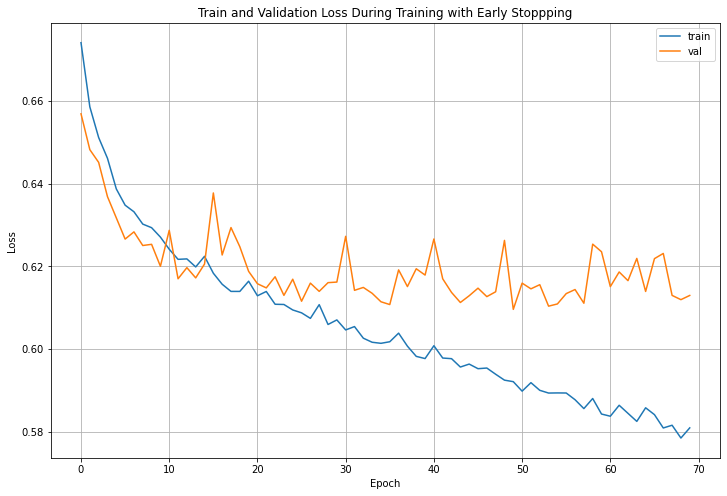

In [92]:
plt.figure(figsize = (12,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.grid(True)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss During Training with Early Stoppping")
plt.legend()
plt.show()

In [93]:
#Baseline Accuracy and F1 Scores
y_pred = baseline_model.predict(X_val)
#Change the prediction to form expected for accuracy and f1-score functions
y_pred = np.round(y_pred.reshape((y_pred.shape[0])))
#Change the validation targets 
y_val = y_val.astype(np.int)
model_base_acc = np.round(accuracy_score(y_pred, y_val), 4) * 100
model_base_f1 = np.round(f1_score(y_pred, y_val), 4) * 100
print(f"Model Baseline Accuracy Score: {model_base_acc:.2f}%")
print(f"Model Baseline F1-Score: {model_base_f1:.2f}%")

Model Baseline Accuracy Score: 66.46%
Model Baseline F1-Score: 56.23%


In [94]:
#Confusion matrix
confusion_matrix(y_pred, y_val)

array([[513, 245],
       [138, 246]], dtype=int64)